In [1]:
import torchattacks
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAMpp, GradCAM
import torchvision.models as models
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import os
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
net = torchvision.models.resnet18(pretrained=False)
# 按训练的规则修改模型
net.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)  # 首层改成3x3卷积核
net.maxpool = nn.MaxPool2d(1, 1, 0)  # 图像太小 本来就没什么特征 所以这里通过1x1的池化核让池化层失效
num_ftrs = net.fc.in_features  # 获取（fc）层的输入的特征数
net.fc = nn.Linear(num_ftrs, 10)

net_dir = 'autodl-tmp/save_model/cifar/res18/epoch=60_test_acc=0.865.pth'
net.load_state_dict(torch.load(net_dir))
net.eval()
net = net.to(device)

In [3]:
# 将数据集转换为PyTorch张量，并将像素值标准化为范围在0到1之间
data_root = './autodl-tmp/cifar-10'
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)
# 如果要运行lenet模型，把下面的lambda这行删掉
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)])
trainset = CIFAR10(root=data_root, train=True,
                 download=False,transform=transform)
testset = CIFAR10(root=data_root, train=False,
                download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=8)

In [4]:
(ims, labs) = next(iter(testloader))	# images：Tensor(64,1,28,28)、labels：Tensor(64,)
ims = ims.to(device)
labs = labs.to(device)

In [5]:
labs = labs.cpu().numpy()

In [6]:
# 计算预训练模型acc
preds = net(ims).cpu().detach().numpy()
class_preds = np.argmax(preds, axis=1)
print(class_preds)
print('test acc', np.sum(class_preds == labs) / 256)

[3 8 8 0 6 6 1 6 5 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 4 2 4 0 9 6 6 5 4 5 9 8 4
 1 9 5 4 6 5 6 0 9 3 9 7 6 9 8 2 3 8 8 7 7 3 3 7 5 6 3 6 2 1 2 6 7 2 6 8 8
 9 2 9 3 5 8 8 1 1 7 2 5 2 7 8 9 0 3 8 6 4 3 6 0 0 7 4 5 6 3 1 1 3 6 8 7 4
 0 6 2 1 3 0 4 6 2 8 3 1 2 8 0 8 3 5 2 4 1 8 9 1 2 9 7 2 8 6 5 6 2 8 7 6 6
 4 2 8 9 6 3 0 5 2 9 3 4 2 1 6 6 8 2 8 4 5 8 9 0 9 8 9 9 3 7 3 0 0 5 2 6 5
 8 6 3 3 0 5 8 7 1 7 2 8 8 7 8 5 1 8 7 1 3 0 5 7 9 7 0 5 9 8 0 7 9 8 2 7 3
 9 4 4 9 6 4 3 6 5 1 5 8 8 0 4 9 5 5 1 1 8 9 0 3 1 9 2 0 5 5 9 9 4 0]
test acc 0.8671875


In [7]:
loaders_scratch = {'train': trainloader, 'test': testloader}
X, Y = iter(loaders_scratch['test']).next()
X, Y = X.to(device), Y.to(device)
Y_logits = net(X)
Y_probs = F.softmax(Y_logits, dim=-1)
Y_preds = Y_probs.argmax(axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


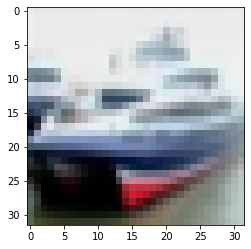

In [8]:
# 你下次打开肯定忘了：这里X是图像，Y是对应的标签，一共10000张。X[1:2][0]是(1,32,32)的一张图
orig_image = X[1:2][0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
orig_image = orig_image * cifar10_std + cifar10_mean
plt.imshow(orig_image)
plt.show()

In [9]:
img_tensor = torch.unsqueeze(ims[1], dim=0).float()
img_variable = Variable(img_tensor, requires_grad=True)
output = net.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
print(label_idx)

8


In [10]:
mnist_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
x_pred = fashion_labels[label_idx]
print(x_pred)

Bag


In [11]:
# PGD
y_true = 8   #change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([8])


In [12]:
# 将图像tensor归一化到0-1中
img_tensor = img_tensor.cpu()
min_val = torch.min(img_tensor)
max_val = torch.max(img_tensor)
img_tensor_normalized = (img_tensor - min_val) / (max_val - min_val)

In [13]:
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
attack = torchattacks.PGD(net, eps=eps[3])
# perturbed_data = (torchattacks.BIM(model, epsilon, 0.2, steps=4))
perturbed_data = attack(img_tensor_normalized, target)

In [14]:
perturbed_data = perturbed_data.cpu()
noise = perturbed_data - img_tensor_normalized

In [15]:
# 去标准化
perturbed_data = perturbed_data * (max_val - min_val) + min_val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


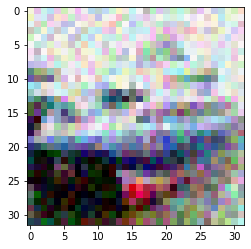

In [16]:
adv_image = perturbed_data[0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
adv_image = adv_image * cifar10_std + cifar10_mean
plt.imshow(adv_image)
plt.show()

In [17]:
noise = noise * (max_val - min_val) + min_val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


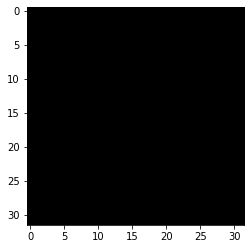

In [25]:
noise_map = noise[0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
adv_image = adv_image * cifar10_std + cifar10_mean
plt.imshow(noise_map)
plt.show()

In [19]:
# 计算图像质量指标
import pytorch_ssim

def psnr(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    psnr = 10 * torch.log10(1/mse)
    return psnr

def mse(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    return mse

def ssim(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    ssim = pytorch_ssim.ssim(img1.float(), img2.float())
    return ssim

In [20]:
mse(perturbed_data, X[1:2]).item()

0.17493610084056854

In [21]:
ssim(X[1:2], perturbed_data).item()

0.6681296229362488

In [22]:
psnr(perturbed_data, X[1:2]).item()

7.5712056159973145